# Assess Replicate Correlation

**Gregory Way, 2019**

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggridges))

In [2]:
set.seed(123)

## Step 0: Load Constants

In [3]:
batch_id <- "2019_04_16_Batch1"
backend_dir <- file.path("..", "..", "backend", batch_id)

## Step 1: Read in Normalized Profiles

In [4]:
profile_files <- list.files(backend_dir,
                            full.names = TRUE,
                            recursive = TRUE,
                            pattern = "_variable_selected.csv")

In [5]:
profile_cols <- readr::cols(
  .default = readr::col_double(),
  Metadata_Plate = readr::col_character(),
  Metadata_Well = readr::col_character(),
  Metadata_Assay_Plate_Barcode = readr::col_character(),
  Metadata_Plate_Map_Name = readr::col_character(),
  Metadata_well_position = readr::col_character(),
  Metadata_cell_line = readr::col_character(),
  Metadata_patient = readr::col_character(),
  Metadata_FFA = readr::col_character(),
  Metadata_diff_day = readr::col_character()
)

In [6]:
profile_df <- purrr::map_df(
    profile_files,
    readr::read_csv,
    col_types = profile_cols
)

dim(profile_df)
head(profile_df, 2)

[1] 530 549

Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_cell_line,Metadata_patient,Metadata_FFA,Metadata_diff_day,Cells_AreaShape_EulerNumber,⋯,Nuclei_Texture_InfoMeas2_DNA_10_01,Nuclei_Texture_InfoMeas2_Mito_10_03,Nuclei_Texture_InverseDifferenceMoment_DNA_10_00,Nuclei_Texture_InverseDifferenceMoment_ER_10_02,Nuclei_Texture_InverseDifferenceMoment_Mito_10_02,Nuclei_Texture_InverseDifferenceMoment_Mito_20_02,Nuclei_Texture_SumAverage_DNA_20_03,Nuclei_Texture_SumVariance_AGP_20_01,Nuclei_Texture_SumVariance_ER_20_03,Nuclei_Texture_SumVariance_Mito_20_01
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BR00101075,B02,BR00101075,BR00101075,B02,vc,PAC_261,0,15,-2.5536390,⋯,-0.9926334,-0.4428927,0.8708758,-0.2420926,0.09550947,0.8396305,-0.04143462,1.0527917,-0.4366555,-0.2189080
BR00101075,B03,BR00101075,BR00101075,B03,sc,PAC_246,0,15,0.7953932,⋯,2.8277974,1.5244484,-2.9259292,-1.0100520,-1.41505458,-1.0412471,-0.48571552,-0.6778352,0.8561962,-0.6286153


## Step 2: Extract Pairwise Correlations

In [7]:
# Separate different cell profiler data
cp_features <- colnames(profile_df) %>%
    stringr::str_subset("^Nuclei_|^Cells_|^Cytoplasm_")

length(cp_features)

cp_metadata <- colnames(profile_df) %>%
    stringr::str_subset("^Metadata_")

length(cp_metadata)

[1] 540

[1] 9

In [8]:
# Create a metadata dictionary and dummy variable "group_id"
# "group_id" distinguishes each separate condition including cell line
# "condition_group_id" distinguishes separate conditions ignoring cell line
metadata_df <- profile_df %>%
    dplyr::select(cp_metadata) %>%
    dplyr::mutate(dictionary_id = paste0("id_", dplyr::row_number()),
                  group_id = group_indices(.,
                                           Metadata_cell_line,
                                           Metadata_patient,
                                           Metadata_FFA,
                                           Metadata_diff_day))

tail(metadata_df)

Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_cell_line,Metadata_patient,Metadata_FFA,Metadata_diff_day,dictionary_id,group_id
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
BR00101083,G06,BR00101083,BR00101083,G06,vc,PAC_266,1,0,id_525,169
BR00101083,G07,BR00101083,BR00101083,G07,sc,PAC_164,1,0,id_526,43
BR00101083,G08,BR00101083,BR00101083,G08,vc,PAC_164,1,0,id_527,115
BR00101083,G09,BR00101083,BR00101083,G09,SGBS,SGBS,1,0,id_528,97
BR00101083,G10,BR00101083,BR00101083,G10,sc,hWAT,1,0,id_529,27
BR00101083,G11,BR00101083,BR00101083,G11,hBAT,hBAT,1,0,id_530,10


In [9]:
# Create a dataframe of variables for each group
group_id_df <- metadata_df %>%
    dplyr::select(
        group_id,
        Metadata_cell_line,
        Metadata_patient,
        Metadata_FFA,
        Metadata_diff_day
    ) %>%
    dplyr::distinct() %>%
    dplyr::arrange(group_id)

dim(group_id_df)
tail(group_id_df)

[1] 177   5

group_id,Metadata_cell_line,Metadata_patient,Metadata_FFA,Metadata_diff_day
<int>,<chr>,<chr>,<chr>,<chr>
172,vc,PAC_266,1,14
173,vc,PAC_266,1,15
174,vc,PAC_266,1,15+iso
175,vc,PAC_266,1,2
176,vc,PAC_266,1,3
177,vc,PAC_266,1,7


In [10]:
table(group_id_df$Metadata_diff_day)


     0      1     10     14     15 15+iso      2      3      7 
    20     20     20     19     20     18     20     20     20 

## Metadata Description

* `Cell Line`
  * `vc` is visceral pre-adipocytes
  * `sc` is subcutaneous pre-adipocytes
* `Patient` - There are 6 patients
  * `PAC_164` - 46 year old male with 53.4 BMI
  * `PAC_246` - 34 year old female with 59.1 BMI
  * `PAC_261` - 38 year old female with 38.4 BMI
  * `PAC_266` - 64 year old male with 43.9 BMI
  * `hBAT` - 56 year old female with 30.8 BMI (Immortalized Line)
  * `hWAT` - same as hBAT?
  * `SGBS` - 3 month old male
* Free Fatty Acids (`FFA`)
  * With or without condition
* `Day`
  * 9 different days - 0, 1, 2, 3, 7, 10, 14, 15, 15+iso
  * day 15 plate with and without isoproterenol

In [11]:
table(
    metadata_df$Metadata_diff_day,
    metadata_df$Metadata_patient,
    metadata_df$Metadata_cell_line,
    metadata_df$Metadata_FFA
)

, ,  = hBAT,  = 0

        
         hBAT hWAT PAC_164 PAC_246 PAC_261 PAC_266 SGBS
  0         3    0       0       0       0       0    0
  1         3    0       0       0       0       0    0
  10        3    0       0       0       0       0    0
  14        3    0       0       0       0       0    0
  15        3    0       0       0       0       0    0
  15+iso    3    0       0       0       0       0    0
  2         3    0       0       0       0       0    0
  3         3    0       0       0       0       0    0
  7         3    0       0       0       0       0    0

, ,  = sc,  = 0

        
         hBAT hWAT PAC_164 PAC_246 PAC_261 PAC_266 SGBS
  0         0    3       3       3       0       3    0
  1         0    3       3       3       0       3    0
  10        0    3       3       3       0       3    0
  14        0    2       3       3       0       3    0
  15        0    3       3       3       0       3    0
  15+iso    0    0       3       3       0       

## Step 3: Get Correlations

In [12]:
cor_df <- profile_df %>%
    dplyr::select(cp_features) %>%
    t() %>%
    cor() %>%
    dplyr::as_tibble() %>%
    magrittr::set_colnames(metadata_df$dictionary_id)

cor_melt_df <- metadata_df %>%
    dplyr::select(-group_id) %>%
    dplyr::bind_cols(
        replace(cor_df,
                lower.tri(cor_df, TRUE), NA)
    ) %>%
    dplyr::select(-cp_metadata) %>%
    reshape2::melt(id.vars = 'dictionary_id',
                   variable.name = 'correlation_id', 
                   value.name = "pearson_cor",
                   na.rm = TRUE) %>%
    tibble::remove_rownames()

dim(cor_melt_df)
head(cor_melt_df)

Warning message:
“`as_tibble.matrix()` requires a matrix with column names or a `.name_repair` argument. Using compatibility `.name_repair`.
This warning is displayed once per session.”

[1] 140185      3

dictionary_id,correlation_id,pearson_cor
<chr>,<fct>,<dbl>
id_1,id_2,-0.02460834
id_1,id_3,0.50359622
id_2,id_3,-0.05287065
id_1,id_4,0.27442777
id_2,id_4,-0.01845614
id_3,id_4,0.33973243


In [13]:
# Map group IDs and condition IDs onto the correlation dataframe
# We are interested in correlations between specific groups
cor_group_df <- cor_melt_df %>%
    dplyr::inner_join(
        metadata_df %>%
        select(dictionary_id,
               group_id),
        by = 'dictionary_id'
    ) %>%
    dplyr::rename(pair_a = group_id) %>%
    dplyr::inner_join(
        metadata_df %>%
        select(dictionary_id,
               group_id),
        by = c('correlation_id' = 'dictionary_id')
    ) %>%
    dplyr::rename(pair_b = group_id,
                  pair_a_id = dictionary_id,
                  pair_b_id = correlation_id)

dim(cor_group_df)
head(cor_group_df)

Warning message:
“Column `correlation_id`/`dictionary_id` joining factor and character vector, coercing into character vector”

[1] 140185      5

pair_a_id,pair_b_id,pearson_cor,pair_a,pair_b
<chr>,<chr>,<dbl>,<int>,<int>
id_1,id_2,-0.02460834,146,56
id_1,id_3,0.50359622,146,128
id_2,id_3,-0.05287065,56,128
id_1,id_4,0.27442777,146,74
id_2,id_4,-0.01845614,56,74
id_3,id_4,0.33973243,128,74


In [14]:
# Remove self correlations and determine median correlation between all groups
# Also create a variable that represents correlations across cell lines within
# the same condition. This variable will be used as the null distribution.
cor_group_df <- cor_group_df %>%
    dplyr::mutate(
        within_group_cor =
            as.numeric(cor_group_df$pair_a == cor_group_df$pair_b),
    ) %>%
    dplyr::filter(cor_group_df$pair_a_id != cor_group_df$pair_b_id) %>%
    dplyr::group_by(
        pair_a,
        pair_b
    ) %>%
    dplyr::mutate(median_cor = median(pearson_cor)) %>%
    dplyr::ungroup() %>%
    dplyr::arrange(desc(median_cor))

dim(cor_group_df)
head(cor_group_df)

[1] 140185      7

pair_a_id,pair_b_id,pearson_cor,pair_a,pair_b,within_group_cor,median_cor
<chr>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>
id_266,id_276,0.9997602,51,51,1,0.9998390
id_266,id_286,0.9999379,51,51,1,0.9998390
id_276,id_286,0.9998390,51,51,1,0.9998390
id_232,id_242,0.9997786,60,60,1,0.9997786
id_232,id_252,0.9993220,60,60,1,0.9997786
id_242,id_252,0.9998492,60,60,1,0.9997786


In [15]:
# Join Replicate Correlations and Null Distribution Correlations
within_group_cor_df <- cor_group_df %>%
    dplyr::filter(within_group_cor == 1) %>%
    dplyr::group_by(pair_b) %>%
    dplyr::mutate(pair_b_median_cor = median(pearson_cor),
                  null_data = "Replicate Correlation") %>%
    dplyr::arrange(desc(pair_b_median_cor)) %>%
    dplyr::ungroup()

null_group_cor_df <- cor_group_df %>%
    dplyr::filter(within_group_cor == 0) %>%
    dplyr::group_by(pair_b) %>%
    dplyr::mutate(pair_b_median_cor = median(pearson_cor),
                  null_data = "Non Replicate Correlation") %>%
    dplyr::arrange(desc(pair_b_median_cor)) %>%
    dplyr::ungroup()

full_plot_ready <- within_group_cor_df %>%
    dplyr::bind_rows(
        null_group_cor_df
    )

dim(full_plot_ready)
head(full_plot_ready)

[1] 140185      9

pair_a_id,pair_b_id,pearson_cor,pair_a,pair_b,within_group_cor,median_cor,pair_b_median_cor,null_data
<chr>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
id_266,id_276,0.9997602,51,51,1,0.9998390,0.9998390,Replicate Correlation
id_266,id_286,0.9999379,51,51,1,0.9998390,0.9998390,Replicate Correlation
id_276,id_286,0.9998390,51,51,1,0.9998390,0.9998390,Replicate Correlation
id_232,id_242,0.9997786,60,60,1,0.9997786,0.9997786,Replicate Correlation
id_232,id_252,0.9993220,60,60,1,0.9997786,0.9997786,Replicate Correlation
id_242,id_252,0.9998492,60,60,1,0.9997786,0.9997786,Replicate Correlation


## Step 4: Generate Figures

In [16]:
# Merge plot ready data with info on group ID
full_plot_ready <- full_plot_ready %>%
    dplyr::left_join(group_id_df, by = c("pair_b" = "group_id"))

head(full_plot_ready, 2)

pair_a_id,pair_b_id,pearson_cor,pair_a,pair_b,within_group_cor,median_cor,pair_b_median_cor,null_data,Metadata_cell_line,Metadata_patient,Metadata_FFA,Metadata_diff_day
<chr>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
id_266,id_276,0.9997602,51,51,1,0.999839,0.999839,Replicate Correlation,sc,PAC_164,1,7
id_266,id_286,0.9999379,51,51,1,0.999839,0.999839,Replicate Correlation,sc,PAC_164,1,7


In [17]:
# Update Factors for plotting
full_plot_ready$Metadata_diff_day <-
    factor(full_plot_ready$Metadata_diff_day,
           levels = c("0", "1", "2", "3", "7", "10", "14", "15", "15+iso"))

# Update Factors for plotting
full_plot_ready$Metadata_cell_line <-
    factor(full_plot_ready$Metadata_cell_line,
           levels = c("hBAT", "SGBS", "sc", "vc"))

Picking joint bandwidth of 0.073
Picking joint bandwidth of 0.0915
Picking joint bandwidth of 0.044
Picking joint bandwidth of 0.0522
Picking joint bandwidth of 0.0434
Picking joint bandwidth of 0.123
Picking joint bandwidth of 0.0608
Picking joint bandwidth of 0.0969
Picking joint bandwidth of 0.0557
Picking joint bandwidth of 0.03
Picking joint bandwidth of 0.0326
Picking joint bandwidth of 0.0569
Picking joint bandwidth of 0.0263
Picking joint bandwidth of 0.036
Picking joint bandwidth of 0.046
Picking joint bandwidth of 0.0347
Picking joint bandwidth of 0.0287
Picking joint bandwidth of 0.008
Picking joint bandwidth of 0.0175
Picking joint bandwidth of 0.0282
Picking joint bandwidth of 0.0295
Picking joint bandwidth of 0.0468
Picking joint bandwidth of 0.0448
Picking joint bandwidth of 0.0393
Picking joint bandwidth of 0.026
Picking joint bandwidth of 0.0498
Picking joint bandwidth of 0.0506
Picking joint bandwidth of 0.0398
Picking joint bandwidth of 0.0686
Picking joint bandwidth

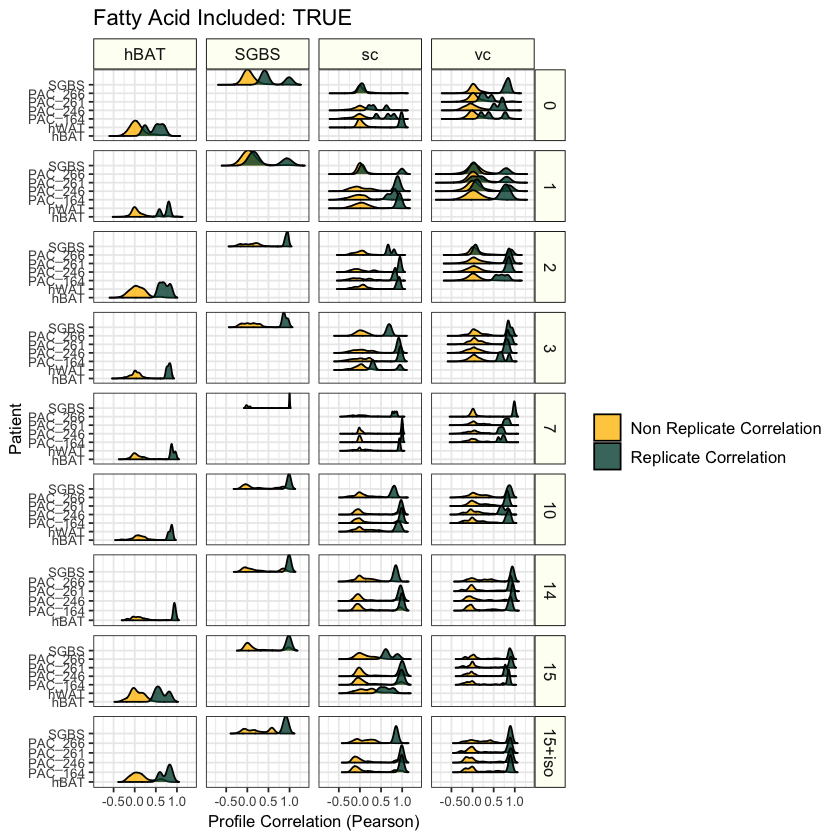

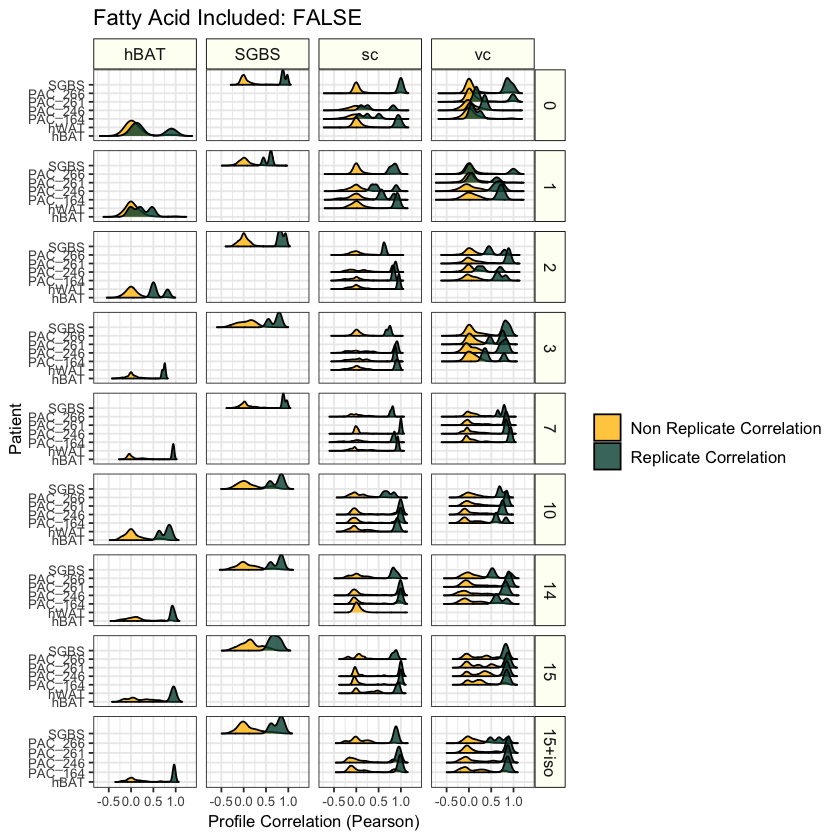

In [18]:
for (fatty_acid in unique(full_plot_ready$Metadata_FFA)) {
    full_plot_subset_df <- full_plot_ready %>%
        dplyr::filter(Metadata_FFA == fatty_acid)
    
    cor_gg <- ggplot(full_plot_subset_df,
                     aes(x = pearson_cor,
                         y = as.factor(Metadata_patient),
                         fill = null_data)) +
        geom_density_ridges(alpha = 0.8) +
        ylab("Patient") +
        xlab("Profile Correlation (Pearson)") +
        theme_bw() +
        ggtitle(paste("Fatty Acid Included:", as.logical(as.numeric(fatty_acid)))) +
        facet_grid(Metadata_diff_day~Metadata_cell_line,
                   scales="free_y") +
        scale_fill_manual(name = "",
                          values = c("#FFC107", "#004D40")) +
        theme(axis.text.y = element_text(size = 8),
              axis.text.x = element_text(size = 8),
              axis.title = element_text(size = 10),
              legend.text = element_text(size = 10),
              strip.text = element_text(size = 10),
              strip.background = element_rect(colour = "black",
                                              fill = "#fdfff4"))
    
    print(cor_gg)
    
    file_base <- file.path("figures", paste0("replicate_correlation_fattyacid_", fatty_acid))
    for (extension in c('.png', '.pdf')) {
        ggsave(cor_gg,
               filename = paste0(file_base, extension),
               height = 10,
               width = 8)
    }
}

In [19]:
    full_plot_group_df = full_plot_ready %>%
        dplyr::filter(pair_b == 1)

In [20]:
table(full_plot_group_df$null_data, full_plot_group_df$within_group_cor)

                           
                               0    1
  Non Replicate Correlation 1464    0
  Replicate Correlation        0    3

## Step 5: Perform KS Test Against Distributions

In [21]:
# Perform KS tests between real and null distributions
all_results <- list()
for (group_id in unique(full_plot_ready$pair_b)) {
    full_plot_group_df = full_plot_ready %>%
        dplyr::filter(pair_b == group_id)

    replicate_corr_df <- full_plot_group_df %>%
        dplyr::filter(within_group_cor == 1)
    null_corr_df <- full_plot_group_df %>%
        dplyr::filter(within_group_cor == 0)

    ks_result = ks.test(x = replicate_corr_df$pearson_cor,
                        y = null_corr_df$pearson_cor,
                        alternative = "less")

    k_stat = as.numeric(ks_result$statistic)
    k_p = as.numeric(ks_result$p.value)
    all_results[[group_id]] <- c(group_id, k_stat, k_p, -log10(k_p), nrow(replicate_corr_df))
}

ks_result_df <- dplyr::as_tibble(do.call(rbind, all_results))
colnames(ks_result_df) <- c("group_id", "ks_stat", "ks_p_value", "ks_log_10_p", "num_replicates")

ks_result_df <- ks_result_df %>% dplyr::arrange(desc(as.numeric(paste(ks_log_10_p))))

dim(ks_result_df)
head(ks_result_df)

[1] 177   5

group_id,ks_stat,ks_p_value,ks_log_10_p,num_replicates
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19,1,0.002509417,2.600427,3
28,1,0.002511439,2.600077,3
116,1,0.002511583,2.600052,3
62,1,0.002511949,2.599989,3
20,1,0.002513746,2.599679,3
31,1,0.002516403,2.599220,3


In [22]:
ks_result_df$group_id <- as.numeric(ks_result_df$group_id)

final_results_df <- full_plot_ready %>%
    dplyr::left_join(ks_result_df,
                     by = c("pair_b" = "group_id")) %>%
    dplyr::group_by(
        Metadata_cell_line,
        Metadata_patient,
        Metadata_FFA,
        Metadata_diff_day
    ) %>%
    dplyr::mutate(
        median_cell_ks = median(ks_stat)
    ) %>%
    dplyr::ungroup() %>%
    dplyr::select(
        Metadata_cell_line,
        Metadata_patient,
        Metadata_FFA,
        Metadata_diff_day,
        ks_stat,
        ks_p_value
    ) %>%
    dplyr::distinct()

head(final_results_df, 2)

Metadata_cell_line,Metadata_patient,Metadata_FFA,Metadata_diff_day,ks_stat,ks_p_value
<fct>,<chr>,<chr>,<fct>,<dbl>,<dbl>
sc,PAC_164,1,7,1,0.002533428
sc,PAC_246,0,7,1,0.002541238


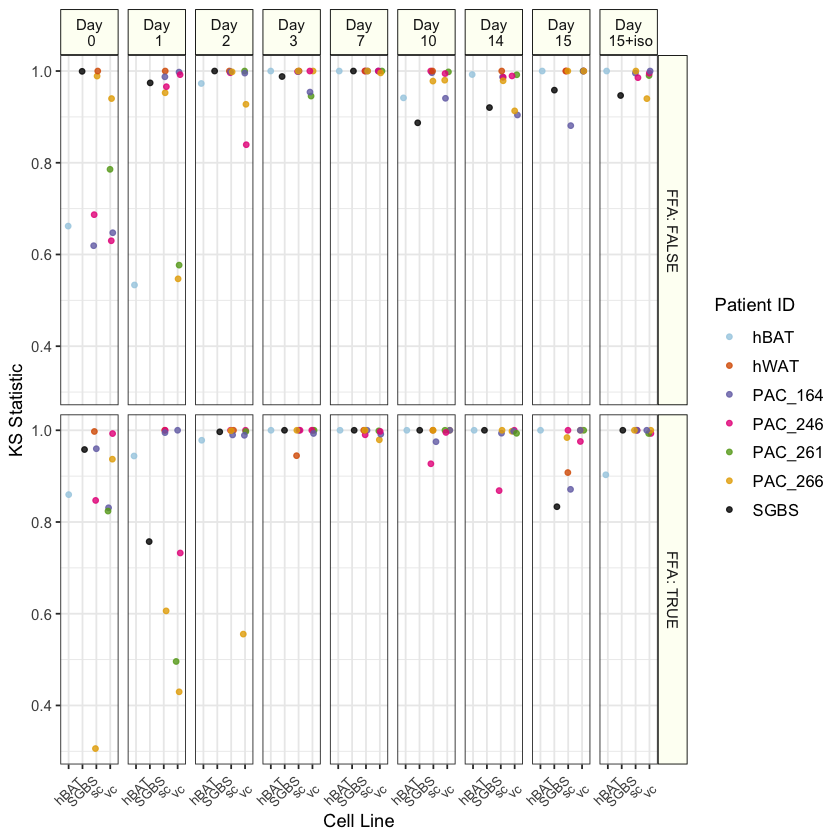

In [23]:
append_ffa <- function(string) paste("FFA:", as.logical(as.numeric(string)))
append_day <- function(string) paste("Day\n", string)

ks_test_gg <- ggplot(final_results_df) +
    geom_jitter(aes(y = ks_stat,
                    x = as.factor(Metadata_cell_line),
                    color = Metadata_patient),
                size = 1.25,
                height = 0,
                width = 0.2,
                alpha = 0.8) +
    scale_color_manual(name = "Patient ID",
                       values = c("#a6cee3",
                                  "#d95f02",
                                  "#7570b3",
                                  "#e7298a",
                                  "#66a61e",
                                  "#e6ab02",
                                  "black")) +
    facet_grid(Metadata_FFA~Metadata_diff_day,
               scales = "free_x",
               labeller = labeller(Metadata_FFA = as_labeller(append_ffa),
                                   Metadata_diff_day = as_labeller(append_day))) +
    xlab("Cell Line") +
    ylab("KS Statistic") +
    theme_bw() +
    theme(axis.text.y = element_text(size = 9),
          axis.text.x = element_text(size = 8, angle = 45, vjust = 0.5),
          axis.title = element_text(size = 11),
          legend.text = element_text(size = 10),
          strip.text = element_text(size = 9),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

ks_test_gg

In [24]:
file_base <- file.path("figures", "replicate_correlation_kstest")
for (extension in c('.png', '.pdf')) {
    ggsave(ks_test_gg,
           filename = paste0(file_base, extension),
           height = 4,
           width = 8)
}